In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)

In [3]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

plot_style_1A = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2A = {'alpha': 0.5, 'density': False}


In [5]:
def get_Dataframe(path, name='Data'):
    Files = listdir(path) 
    #print (Files)
    df = None
    for f in Files:
        if name not in f: continue
        filename = path+f
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        for key in temp_file[name].keys():
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
        if 'Data' not in name:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y",'gen_y',"e_*","gene*"], entrystop=3e6,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*","Q2","y","e_*"], entrystop=3e6,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    print('Dataframe has a total of ', df.shape[0], ' entries')
    print('####################################################################')

    return df


In [6]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [7]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('jet_px = jet_pt*cos(jet_phi)', inplace=True)
    temp.eval('jet_py = jet_pt*sin(jet_phi)', inplace=True)
    temp.eval('jet_qt = sqrt( (jet_px + e_px)**2 + (jet_py + e_py)**2) ', inplace=True)
    temp.eval('jet_qtnorm = jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)
    temp.eval('jet_phi = arctan(jet_py/jet_px)',inplace=True)
    temp.eval('jet_dphi = e_phi-jet_phi',inplace=True)
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('Q = sqrt(Q2)', inplace=True)
    temp = applyCut(temp, '0.08 < y < 0.7', '0.08 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt>5.0', 'jet pT > 5 GeV')
    temp = applyCut(temp, 'pass_reco==0 | jet_eta>-1.0', 'jet eta > -1.0')
    temp = applyCut(temp, 'pass_reco==0 | jet_eta<2.5', 'jet eta < 2.5')

    if(isMC):
        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gen_Q    = sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        temp.eval('genjet_px = genjet_pt*cos(genjet_phi)', inplace=True)
        temp.eval('genjet_py = genjet_pt*sin(genjet_phi)', inplace=True)
        temp.eval('genjet_qt = sqrt( (genjet_px + gene_px)**2 + (genjet_py + gene_py)**2) ', inplace=True)
        temp.eval('genjet_qtnorm = genjet_qt/sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_phi = arctan(gene_py/gene_px)', inplace=True)
        temp.eval('genjet_phi = arctan(genjet_py/genjet_px)',inplace=True)
        temp.eval('genjet_dphi = gene_phi-genjet_phi',inplace=True)
        
    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [8]:
mc_name = 'Django'
altmc_name = 'Rapgap'

#altmc_name = 'Rapgap'
#mc_name = 'Django'

In [10]:
#path= '/data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/'
#path = '/data0/users/marratia/HERAdata/out_ep0607/'
path = '/data0/users/marratia/HERAdata/test21/out_ep0607/'
data = get_Dataframe(path, name='Data')

filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Data_Eplus0607_0.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Data_Eplus0607_2.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Data_Eplus0607_3.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Data_Eplus0607_1.root
####################################################################
Dataframe has a total of  371425  entries
####################################################################


In [12]:
mc = get_Dataframe(path, name=mc_name)


filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_125.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_116.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_153.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_18.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_107.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_143.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_137.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_127.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_120.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_129.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Django_Eplus0607_4.root
file has not minitree, skipping
filename is /d

In [11]:
altmc = get_Dataframe(path, name=altmc_name)


filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_118.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_12.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_9.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_144.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_115.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_101.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_108.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_116.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_143.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_128.root
filename is /data0/users/marratia/HERAdata/test21/out_ep0607/Rapgap_Eplus0607_147.root
filename is /data0/users/marratia/HERAdata/tes

## Defining pass reco and pass truth variables

In [13]:
mc['pass_reco'] = np.where(mc['jet_pt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['jet_pt']>0, 1, 0)
altmc['pass_reco'] = np.where(altmc['jet_pt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['jet_pt']>0, 1, 0)
data['pass_reco'] = np.where(data['jet_pt']>0, 1, 0)

In [14]:
mc.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'genjet_pt', 'genjet_phi',
       'genjet_eta', 'Q2', 'gen_Q2', 'y', 'gen_y', 'e_px', 'e_py', 'e_pz',
       'gene_px', 'gene_py', 'gene_pz', 'pass_reco', 'pass_truth'],
      dtype='object')

## Event selection

In [15]:
print('Selecting data events\n')
data = applyCutsJets(data)
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('alt mc\n')
altmc = applyCutsJets(altmc, isMC=True)

Selecting data events

0.08 < y < 0.7 301739  fraction kept: 81.2
Q2>150 260420  fraction kept: 86.3
jet pT > 5 GeV 260420  fraction kept: 100.0
jet eta > -1.0 254050  fraction kept: 97.6
jet eta < 2.5 250736  fraction kept: 98.7
Selecting MC events

0.08 < y < 0.7 25452538  fraction kept: 91.8
Q2>150 21559012  fraction kept: 84.7
jet pT > 5 GeV 21559012  fraction kept: 100.0
jet eta > -1.0 21117926  fraction kept: 98.0
jet eta < 2.5 20922302  fraction kept: 99.1
alt mc

0.08 < y < 0.7 20657930  fraction kept: 91.3
Q2>150 17776038  fraction kept: 86.0
jet pT > 5 GeV 17776038  fraction kept: 100.0
jet eta > -1.0 17373959  fraction kept: 97.7
jet eta < 2.5 17242873  fraction kept: 99.2


In [16]:
label_DISselection = r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$'

In [17]:
mc.head()

jet_pt   jet_phi      jet_eta  jet_dphi  genjet_pt  \
entry subentry                                                            
0     0            6.346505 -0.173993    -0.817739  0.393163   8.048365   
      1        -9999.000000  0.689416 -9999.000000 -0.470246   3.584716   
1     0           18.917841  1.557546     1.550053 -0.192284  17.776318   
      1            8.957378 -0.770226     1.325852  2.135488   5.746510   
3     0           43.779816 -0.446670     1.627928 -0.016861  44.776558   

                genjet_phi  genjet_eta           Q2       gen_Q2         y  \
entry subentry                                                               
0     0          -0.347618   -0.796562   189.964752   192.151474  0.627049   
      1           1.057603   -0.918996   189.964752   192.151474  0.627049   
1     0          -1.525192    1.589895   284.793488   286.446198  0.139416   
      1          -0.849629    1.289544   284.793488   286.446198  0.139416   
3     0          -0.401520    1.529508  2275.745605  2342.706543  0.204995   

                ...          Q  gen_logQ2      gen_Q    gene_pt  genjet_px  \
entry subentry  ...                                                          
0     0         ...  13.782770   2.283644  13.861871   8.673979  -7.566966   
      1         ...  13.782770   2.283644  13.861871   8.673979  -1.759958   
1     0         ...  16.875826   2.457043  16.924721  15.824150  -0.810404   
      1         ...  16.875826   2.457043  16.924721  15.824150   3.794200   
3     0         ...  47.704777   3.369718  48.401512  43.376900 -41.215389   

                genjet_py  genjet_qt  genjet_qtnorm  gene_phi  genjet_dphi  
entry subentry                                                              
0     0          2.741752   4.722589       0.340689  0.220218     0.567836  
      1         -3.122938   6.816107       0.491716  0.220218    -0.837385  
1     0         17.757835   4.655257       0.275057  1.363750     2.888942  
      1         -4.315834  19.809412       1.170442  1.363750     2.213379  
3     0         17.499487   3.073585       0.063502 -0.463621    -0.062100  

[5 rows x 36 columns]

## Plot a few distributions at reco and truth level 

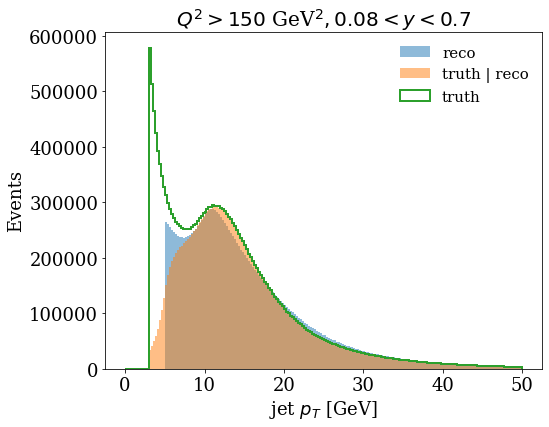

In [18]:
fig = plt.figure(figsize=(8,6))
plt.hist(mc.query('pass_reco==1 ')['jet_pt'],range=(0,50),bins=200,label='reco',alpha=0.5)
plt.hist(mc.query('pass_reco==1 ')['genjet_pt'],range=(0,50),bins=200, label='truth | reco',alpha=0.5)
plt.hist(mc['genjet_pt'],range=(0,50),bins=200, label='truth',histtype='step',lw=2)
plt.xlabel(r'jet $p_{T}$ [GeV]')
plt.ylabel('Events')
plt.legend(loc='best')
plt.tight_layout()
plt.title(label_DISselection,fontsize=20)
plt.show()
fig.savefig('figures/Jetptspectrum_reco_truth')    

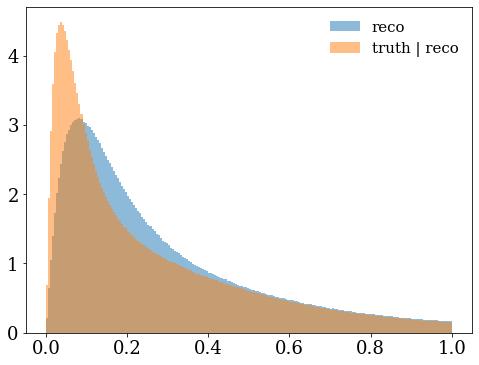

In [19]:
fig = plt.figure(figsize=(8,6))

#plt.hist(mc.query('pass_reco==1')['e_pt'],range=(0,50),bins=200,**plot_style_2)
plt.hist(mc.query('pass_reco==1 and jet_pt>10')['jet_qtnorm'],range=(0,1),bins=200,**plot_style_2,label='reco')
#plt.hist(altmc.query('pass_reco==1 and jet_pt>10')['jet_qtnorm'],range=(0,3),bins=200,**plot_style_2,label='alt mc reco')

plt.hist(mc.query('pass_reco==1 and jet_pt>10')['genjet_qtnorm'],range=(0,1),bins=200,**plot_style_2, label='truth | reco')
#plt.hist(mc['genjet_qtnorm'],range=(0,3),bins=200,**plot_style_1, label='truth')
plt.legend(loc='best')
plt.show()

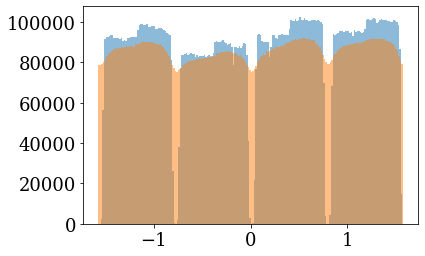

In [20]:
plt.hist(mc.query('pass_reco==1')['e_phi'],bins=200,alpha=0.5)
plt.hist(mc.query('pass_reco==1')['jet_phi'],bins=200,alpha=0.5)

#plt.hist(mc.query('pass_reco==1')['jet_phi'],bins=200,alpha=0.5)

plt.show()

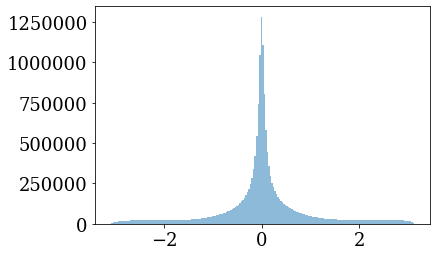

In [21]:
plt.hist(mc.query('pass_reco==1')['jet_dphi'],bins=200,alpha=0.5)
#plt.yscale('log')
plt.show()



In [ ]:
mc_cut = mc[:15000000]
altmc_cut = altmc[:1500000]

In [22]:
print(len(data))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts
print(len(altmc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts


250736


NameError: name 'mc_cut' is not defined

### Define UniFold Algorithm


In [31]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages

## Define features using just MC and alt MC *this is CLOSURE TEST*

In [ ]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_G = altmc_cut['gene_px']
epx_unknown_S = altmc_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_G = altmc_cut['gene_py']
epy_unknown_S = altmc_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_G = altmc_cut['gene_pz']
epz_unknown_S = altmc_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_G = altmc_cut['genjet_pt']
jetpt_unknown_S = altmc_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_G = altmc_cut['genjet_phi']
jetphi_unknown_S = altmc_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_G = altmc_cut['genjet_eta']
jeteta_unknown_S = altmc_cut['jet_eta']


jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']
jetdphi_unknown_G = altmc_cut['genjet_dphi']
jetdphi_unknown_S = altmc_cut['jet_dphi']


#jetqt_0_G       = np.log10(mc_cut['genjet_qtnorm'])
#jetqt_0_S       = np.log10(mc_cut['jet_qtnorm'])
#jetqt_unknown_G = np.log10(altmc_cut['genjet_qtnorm'])
#jetqt_unknown_S = np.log10(altmc_cut['jet_qtnorm'])

jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']
jetqt_unknown_G = altmc_cut['genjet_qt']
jetqt_unknown_S = altmc_cut['jet_qt']

Q_0_G       = mc_cut['gen_Q']
Q_0_S       = mc_cut['Q']
Q_unknown_G = altmc_cut['gen_Q']
Q_unknown_S = altmc_cut['Q']


In [ ]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G, Q_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S, Q_0_S)]
theta_unknown_G =np.c_[(epx_unknown_G, epy_unknown_G, epz_unknown_G, jetpt_unknown_G, jeteta_unknown_G, jetphi_unknown_G, jetdphi_unknown_G, jetqt_unknown_G, Q_unknown_G)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S, Q_unknown_S)]


In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

In [ ]:
bins = np.linspace(2,5, 101)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)


ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

bins = np.linspace(-5,50, 101)
#bins = np.linspace(0,2, 101)
#bins = np.linspace(0,1,100)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)

ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)






plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Define Multifold 

In [34]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S,verbose=1):
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    

    weights = np.empty(shape=(iterations, 2, len(theta0_G))) #this was 0
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))

    inputs = Input((num_observables, ))
     #inputs = Input((2, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                              verbose=verbose,
                              restore_best_weights=True)
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data (not MC weights)

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        #theta0_G[theta0_S[:,0]!=-10][:,1]
        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_1[X_train_1[:,0]!=-10],
              Y_train_1[X_train_1[:,0]!=-10],
              sample_weight=w_train_1[X_train_1[:,0]!=-10],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1[:,0]!=-10], Y_test_1[X_test_1[:,0]!=-10], w_test_1[X_test_1[:,0]!=-10]),
              callbacks=[earlystopping],
              verbose=verbose)

        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1. #these are events that don't pass reco; take the prior.
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=verbose)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_push
    return weights, model

## Unfold

In [ ]:
K.clear_session()

In [ ]:
iterations = 4# use ~4 iterations
num_observables= 9

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S, verbose=0)

## Put weights into MC dataframe

In [ ]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

## Check that weights are reasonable

In [ ]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Remove some large weights 

In [ ]:
print(len(mc_cut))
mc_cut.query('weight_truth>10000')
print(len(mc_cut.query(' weight_reco>0.01')))

mc_cut = mc_cut.query('weight_reco<100 and weight_reco>0.01')
#altmc_cut = altmc_cut.query('weight_truth<10000')
print(len(mc_cut))

mc_cut = mc_cut.query('weight_truth<100 and weight_truth>0.01')
print(len(mc_cut))

## Closure Test

In [ ]:
event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
#track_selection = 'gen_track_pt>0.2'
jet_selection    = 'genjet_pt>10'
query = 'pass_reco==1 and ' + event_selection + ' and ' + jet_selection
print('The query is:' , query)

label1 = mc_name +' truth'
label2 = altmc_name + ' unfold.'
label3 = altmc_name + ' truth '


for i in range(len(weights)):
    if(i<2): continue
    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    
    ax = ax.flatten()
    
    bins = np.linspace(0.0, 1.0,40 )

    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0].hist(altmc_cut.query(query)['gen_y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0].legend(frameon=False)

    bins = np.linspace(2, 5,50 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1].hist(altmc_cut.query(query)['gen_logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[1].legend(frameon=False)

    

    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel(r'jet $p_{T}$',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['genjet_pt'], bins=bins, label=label1, **plot_style_2)
    ax[2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[2].hist(altmc_cut.query(query)['genjet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[2].legend(frameon=False)


    bins = np.linspace(-1.5,3,25 )

    ax[3].set_xlabel(r'jet $\eta$',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['genjet_eta'], bins=bins, label=label1, **plot_style_2)
    ax[3].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[3].hist(altmc_cut.query(query)['genjet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[3].legend(frameon=False)

    bins = np.linspace(0,100,50)

    ax[4].set_xlabel(r'electron $p_{T}$',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[4].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[4].hist(altmc_cut.query(query)['gene_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[4].legend(frameon=False,loc='best')
    
    
    
    bins = np.linspace(0,2.5,20)

    ax[5].set_xlabel(r'jet $q_{T}/Q$',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['genjet_qtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[5].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[5].hist(altmc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[5].legend(frameon=False,loc='best')
    
    
    
    bins = np.linspace(-np.pi,np.pi,50)

    ax[6].set_xlabel(r'jet $\phi$',fontsize=22)
    ax[6].set_ylabel('Events per bin (Normalized)')
    ax[6].hist(mc_cut.query(query)['genjet_phi'], bins=bins, label=label1, **plot_style_2)
    ax[6].hist(mc_cut.query(query)['genjet_phi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[6].hist(altmc_cut.query(query)['genjet_phi'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[6].legend(frameon=False,loc='best')
    

    bins = np.linspace(-np.pi,np.pi,50)

    ax[7].set_xlabel(r'electron-jet $\Delta\phi$',fontsize=22)
    ax[7].set_ylabel('Events per bin (Normalized)')
    ax[7].hist(mc_cut.query(query)['genjet_dphi'], bins=bins, label=label1, **plot_style_2)
    ax[7].hist(mc_cut.query(query)['genjet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[7].hist(altmc_cut.query(query)['genjet_dphi'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[7].legend(frameon=False,loc='best')
    ax[7].set_yscale('log')

    fig.savefig('figures/Closure_inclusivejet_%i_iter_%s_%s.png'%(i,mc_name, altmc_name))

## Show the reweighting of the reco

In [ ]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = mc_name +' reco'
label2 = mc_name +' wgt.'
label3 = altmc_name +' reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):
    if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )
    
    ax = ax.flatten()

    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0].hist(altmc_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1].hist(altmc_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel('jet $p_{T}$',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['jet_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[2].hist(altmc_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,3,25 )

    ax[3].set_xlabel('jet $\eta $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['jet_eta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[3].hist(altmc_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,20)
    
    ax[4].set_xlabel('jet $q_{T}/Q $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[4].hist(altmc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[4].legend(frameon=False,loc='best')
    ax[4].set_yscale('log')

   
    bins = np.linspace(0,100,50)

    ax[5].set_xlabel(r'electron $p_{T}$',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[5].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[5].hist(altmc_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[5].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(-np.pi,np.pi,50)

    ax[6].set_xlabel(r'jet $\phi$',fontsize=22)
    ax[6].set_ylabel('Events per bin (Normalized)')
    ax[6].hist(mc_cut.query(query)['jet_phi'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[6].hist(mc_cut.query(query)['jet_phi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[6].hist(altmc_cut.query(query)['jet_phi'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    ax[6].legend(frameon=False,loc='best')
    

    bins = np.linspace(-np.pi,np.pi,50)

    ax[7].set_xlabel(r'electron-jet $\Delta\phi$',fontsize=22)
    ax[7].set_ylabel('Events per bin (Normalized)')
    ax[7].hist(mc_cut.query(query)['jet_dphi'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[7].hist(mc_cut.query(query)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[7].hist(altmc_cut.query(query)['jet_dphi'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[7].legend(frameon=False,loc='best')
    ax[7].set_yscale('log')
    
    plt.tight_layout()
    fig.savefig('figures/DataMC_comparison_inclusivejet_%i_iter_%s_%s.png'%(i,mc_name, altmc_name)) 
    
    

## Check re-weighting at reco level for differential plots

In [ ]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.linspace(-np.pi,np.pi,100)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(24,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(12,25), (25,50),(50,100)]):
    #cut = ' Q2 > %2.2f and Q2 <%2.2f and pass_reco==1'%(edges[0],edges[1])
    cut = 'Q>%2.2f and Q<%2.2f and pass_reco==1 and jet_pt>10'%(edges[0],edges[1])
    print (cut)
    print ('###########')

    axs[counter].xaxis.set_label_text(r'electron-jet $\Delta\phi$', fontsize=25)


    
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'], bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(cut)['weight_reco'],
               label=mc_name +' reco wgt.',
               **plot_style_1)
    axs[counter].hist(altmc_cut.query(cut)['jet_dphi'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)    
    
    
    axs[counter].legend(prop={'size': 16}, frameon=False, loc='upper left')
    axs[counter].set_title(' $ %2.0f< Q < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)

fig.savefig('figures/DataMCcomparison_dphi_diff_%s_%s.png'%(mc_name,altmc_name)) 


In [ ]:
bins = np.linspace(-np.pi/2.0,np.pi/2.0,40 )
#query = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
query  = 'pass_reco==1 and gen_Q>30'
#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_dphi'], bins=bins, label=label1, **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

plt.hist(altmc_cut.query(query)['jet_dphi'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
plt.yscale('log')
plt.legend(frameon=False,loc='best')

In [ ]:
query = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7 and pass_reco==1'

plt.hist(mc_cut.query(query)['genjet_pt'], bins=bins, label='Django truth', **plot_style_2)
plt.hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label='Unfolded',
               **plot_style_1)

plt.hist(altmc_cut.query(query)['genjet_pt'],
               bins=bins,
               label='Rapgap truth',
               **plot_style_2)

plt.xlabel(r'$jet p_{T} $',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
plt.legend(frameon=False)

## Closure Test  jet pT spectrum

In [ ]:
plt.hist(altmc_cut.query(cut)['genjet_qtnorm'],range=(0,0.1),bins=100,label='Rapgap Truth')
plt.yscale('log')


In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
cut = cut + ' and pass_reco==1'
bins = np.logspace(np.log10(10),np.log10(100),8)
#bins = np.array([10,14,21,29,47,71,127])

ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label= mc_name+' Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label=altmc_name+' Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = altmc_name+' unfolded',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_xlabel('$p_{T}^{jet}$ [GeV]')
ax[1].set_xlabel('$p_{T}^{jet}$ [GeV]')

ax[0].set_ylabel('Events per bin (Normalized)')
ax[1].set_ylabel('Unfolded/Truth')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.90,1.1,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

#lt.tight_layout()
fig.savefig('figures/Closure_jetpt_%s_%s.png'%(mc_name, altmc_name))  

plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
cut = cut + ' and pass_reco==1'

#bins = np.linspace(0,3,6)
bins = np.logspace(np.log10(0.03),np.log10(3),8)
ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,label=mc_name + ' Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,label=altmc_name+ ' Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = altmc_name+' unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_yscale('log')

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.9,1.1,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

ax[0].set_xlabel('jet $q_{T}/Q$')
ax[1].set_xlabel('jet $q_{T}/Q$')

ax[0].set_ylabel('Events per bin (Normalized)')
ax[1].set_ylabel('Unfolded/Truth')

#plt.tight_layout()
fig.savefig('figures/Closure_jetqt_%s_%s.png'%(mc_name, altmc_name))  


plt.show()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'# and genjet_pt<20 '
cut = cut + ' and pass_reco==1'
bins = np.linspace(-np.pi/2.0,np.pi/2.0,20) 
ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,label=mc_name+' Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_dphi'],bins=bins,label=altmc_name+ ' Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = altmc_name+' unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_yscale('log')
#ax[0].set_xscale('log')
ax[0].set_title('$Q^{2}>150$ GeV$^{2}$, $0.2<y<0.7$, $p_{T}^{jet}>10$ GeV',fontsize=20)

ax[0].set_xlabel('electron-jet $\Delta\phi$ [rad]')
ax[1].set_xlabel('electron-jet $\Delta\phi$ [rad]')

ax[0].set_ylabel('Events per bin (Normalized)')
ax[1].set_ylabel('Unfolded/Truth')

ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])
fig.savefig('figures/Closure_dphi_%s_%s.png'%(mc_name, altmc_name))  

plt.show()

## Closure for dphi but differentially in Q

In [ ]:
cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'# and genjet_pt<20 '
cut = cut + ' and pass_reco==1'
bins = np.linspace(-np.pi/2.0,np.pi/2.0,40) 

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(24,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(12,20), (20,30),(30,100)]):
    cut = ' gen_Q > %2.2f and gen_Q<%2.2f and gen_y>0.2 and gen_y<0.7'%(edges[0],edges[1])
    cut = cut + ' and genjet_pt>10'# and genjet_pt<20 '
    cut = cut + ' and pass_reco==1'#cut = ' Q2 > %2.2f and Q2 <%2.2f and pass_reco==1'%(edges[0],edges[1])
    #cut = 'Q>%2.2f and Q<%2.2f and pass_reco==1 and jet_pt>10'%(edges[0],edges[1])
    print (cut)
    print ('###########')

    axs[counter].xaxis.set_label_text(r'electron-jet $\Delta\phi$', fontsize=25)


    
    axs[counter].hist(mc_cut.query(cut)['genjet_dphi'], bins=bins, label=mc_name+' reco', **plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['genjet_dphi'],
               bins=bins,
               weights=mc_cut.query(cut)['weight_truth'],
               label= altmc_name + ' unfold.',
               **plot_style_1)
    axs[counter].hist(altmc_cut.query(cut)['genjet_dphi'],
               bins=bins,
               label=altmc_name + ' truth',
               **plot_style_2)    
    
    
    axs[counter].legend(prop={'size': 16}, frameon=False, loc='upper left')
    axs[counter].set_title(' $ %2.0f< Q < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)

fig.savefig('figures/Closure_dphi_diff_%s_%s.png'%(mc_name,altmc_name)) 

## check weights

In [ ]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Compute some efficiency

In [ ]:
fig= plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(5),np.log10(100),20)
num,x,_  = plt.hist(mc_cut.query('pass_reco==1')['genjet_pt'], weights=mc_cut.query('pass_reco==1')['weight_truth'],bins=bins,label='numerator, weighted',alpha=0.5)
den,x,_  = plt.hist(mc_cut['genjet_pt'], weights=mc_cut['weight_truth'],bins=bins,label='denominator, weighted',alpha=0.5)
x= (x[1:] + x[:-1])/2.0

plt.xlabel('jet $p_{T}$ [GeV]')
plt.legend()
plt.show()
eff_weighted= np.true_divide(num,den)

plt.tight_layout()

fig.savefig('figures/efficiency_part1.png')  


In [ ]:


fig= plt.figure(figsize=(8,6))

plt.xlabel('jet $p_{T}$ [GeV]')
plt.ylabel('Efficiency')

plt.plot(x,eff_weighted,'o')
plt.xscale('log')
#plt.tight_layout()
plt.tight_layout()

fig.savefig('figures/efficiency_part2.png')  


In [ ]:
K.clear_session()

## Define features with data

In [24]:
mc_cut = mc[:5000000]
altmc_cut = altmc#[:1000000]
data_cut = data#[:50000]

print(len(mc_cut))
print(len(data_cut))

5000000
250736


In [ ]:
#mc_cut = pd.concat([mc_cut, altmc_cut])

In [25]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


250736
4102741
5000000


In [26]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_S = data_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_S = data_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_S = data_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_S = data_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_S = data_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_S = data_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']
jetdphi_unknown_S = data_cut['jet_dphi']


#jetqt_0_G       = mc_cut['genjet_qtnorm'])
#jetqt_0_S       = np.log10(mc_cut['jet_qtnorm'])
#jetqt_unknown_S = np.log10(data_cut['jet_qtnorm'])
jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']
jetqt_unknown_S = data_cut['jet_qt']

Q_0_G           = mc_cut['gen_Q']
Q_0_S           = mc_cut['Q']
Q_unknown_S     = data_cut['Q']

In [27]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G, Q_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S, Q_0_S)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S, Q_unknown_S)]


In [28]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

In [29]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


250736
4102741
5000000


## Run unfolding on data

In [32]:
K.clear_session()

In [35]:
iterations = 4# use ~4 iterations
num_observables= 9

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S, verbose=0)


ITERATION: 1

STEP 1



/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide



STEP 2


ITERATION: 2

STEP 1



/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply



STEP 2


ITERATION: 3

STEP 1


STEP 2


ITERATION: 4

STEP 1


STEP 2



## Incorporate weights into the dataframe

In [36]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Check weights

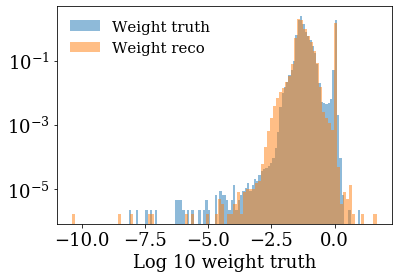

Iteration 0
360.0255126953125 0.0020461305975914
364.3893127441406 9.695733024273068e-05
 
Iteration 1
42.489078521728516 0.0043010651133954525
89.6636962890625 0.002034345641732216
 
Iteration 2
9.186882972717285 8.243741689284434e-09
28.075458526611328 2.6820193852472585e-06
 
Iteration 3
10.138223648071289 7.309695959634155e-09
45.627296447753906 4.0611066592921574e-11
 


In [37]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print ('Iteration %i'%i)
    print(max(weights[i, 1, :]), min(weights[i, 1, :]))    
    print(max(weights[i, 0, :]), min(weights[i, 0, :]))
    print(' ')

In [38]:
print(len(mc_cut))
mc_cut.query('weight_truth>10000')
print(len(mc_cut.query(' weight_reco>0.01')))

mc_cut = mc_cut.query('weight_reco<1000 and weight_reco>0.001')
#altmc_cut = altmc_cut.query('weight_truth<10000')
print(len(mc_cut))

mc_cut = mc_cut.query('weight_truth<1000 and weight_truth>0.001')
print(len(mc_cut))

5000000
4980315
4999943
4999888


ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4


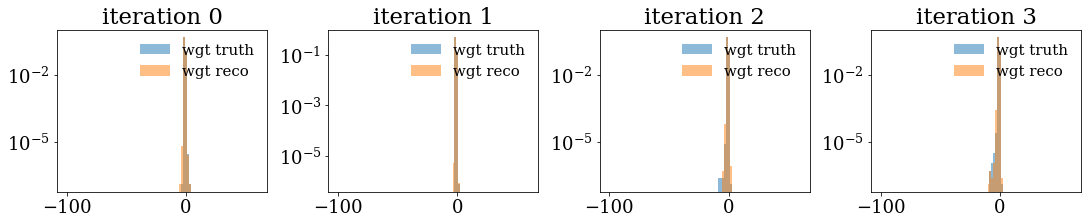

In [39]:
fig, ax = plt.subplots(1,
                           4,
                           figsize=(15, 3),
                           constrained_layout=True)
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    #bins = np.linspace(5, 50, 45)

    
    ax[i].hist(np.log10(weights[i, 1, :][~np.isnan(weights[i, 1, :])]),bins=100,range=(-100,60),**plot_style_2,label='wgt truth')
    ax[i].hist(np.log10(weights[i, 0, :][~np.isnan(weights[i, 0, :])]),bins=100,range=(-100,60),**plot_style_2, label='wgt reco') 
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_title('iteration %i'%i)

    #ax[i].xlabel('Log 10 weight truth')

## Incorporate weights into the dataframe

In [41]:
mc_cut.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'genjet_pt', 'genjet_phi',
       'genjet_eta', 'Q2', 'gen_Q2', 'y', 'gen_y', 'e_px', 'e_py', 'e_pz',
       'gene_px', 'gene_py', 'gene_pz', 'pass_reco', 'pass_truth', 'jet_px',
       'jet_py', 'jet_qt', 'jet_qtnorm', 'e_pt', 'e_phi', 'logQ2', 'Q',
       'gen_logQ2', 'gen_Q', 'gene_pt', 'genjet_px', 'genjet_py', 'genjet_qt',
       'genjet_qtnorm', 'gene_phi', 'genjet_dphi', 'weight_reco',
       'weight_truth'],
      dtype='object')

## MC at reco level reweighted vs data

The query is: pass_reco==1 
ITERATION: 3


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:170: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


ITERATION: 4


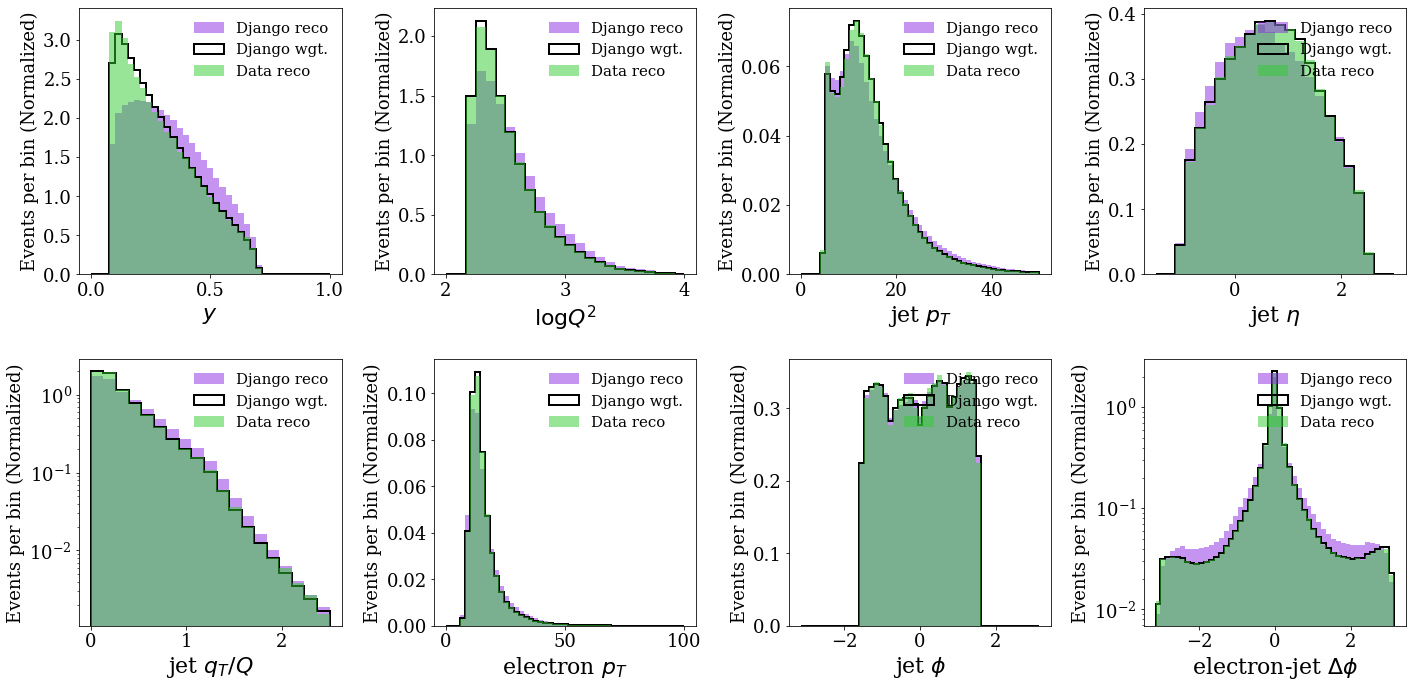

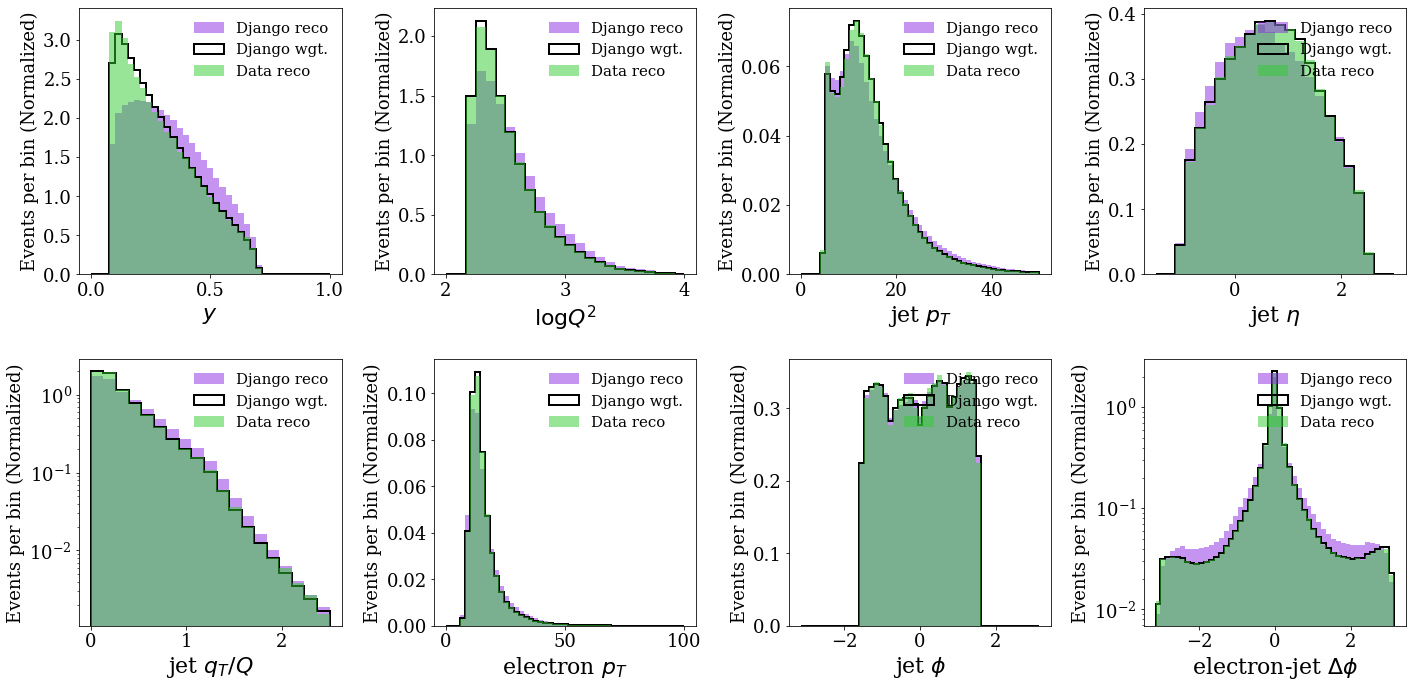

In [42]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = mc_name +' reco'
label2 = mc_name +' wgt.'
label3 = 'Data reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):
    if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )
    
    ax = ax.flatten()

    ax[0].set_xlabel(r'$y$',fontsize=22)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[2].set_xlabel('jet $p_{T}$',fontsize=22)
    ax[2].set_ylabel('Events per bin (Normalized)')
    ax[2].hist(mc_cut.query(query)['jet_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,3,25 )

    ax[3].set_xlabel('jet $\eta $',fontsize=22)
    ax[3].set_ylabel('Events per bin (Normalized)')
    ax[3].hist(mc_cut.query(query)['jet_eta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,20)
    
    ax[4].set_xlabel('jet $q_{T}/Q $',fontsize=22)
    ax[4].set_ylabel('Events per bin (Normalized)')
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[4].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[4].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[4].legend(frameon=False,loc='best')
    ax[4].set_yscale('log')

   
    bins = np.linspace(0,100,50)

    ax[5].set_xlabel(r'electron $p_{T}$',fontsize=22)
    ax[5].set_ylabel('Events per bin (Normalized)')
    ax[5].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[5].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[5].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[5].legend(frameon=False,loc='best')
    
    
    bins = np.linspace(-np.pi,np.pi,50)

    ax[6].set_xlabel(r'jet $\phi$',fontsize=22)
    ax[6].set_ylabel('Events per bin (Normalized)')
    ax[6].hist(mc_cut.query(query)['jet_phi'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[6].hist(mc_cut.query(query)['jet_phi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[6].hist(data_cut.query(query)['jet_phi'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    ax[6].legend(frameon=False,loc='best')
    

    bins = np.linspace(-np.pi,np.pi,50)

    ax[7].set_xlabel(r'electron-jet $\Delta\phi$',fontsize=22)
    ax[7].set_ylabel('Events per bin (Normalized)')
    ax[7].hist(mc_cut.query(query)['jet_dphi'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[7].hist(mc_cut.query(query)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[7].hist(data_cut.query(query)['jet_dphi'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[7].legend(frameon=False,loc='best')
    ax[7].set_yscale('log')
    
    plt.tight_layout()
    fig.savefig('figures/RealDataMC_comparison_inclusivejet_%i_iter_%s.png'%(i,mc_name)) 
    
    

## Plot unfolded results

The query is: pass_reco==1
ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4


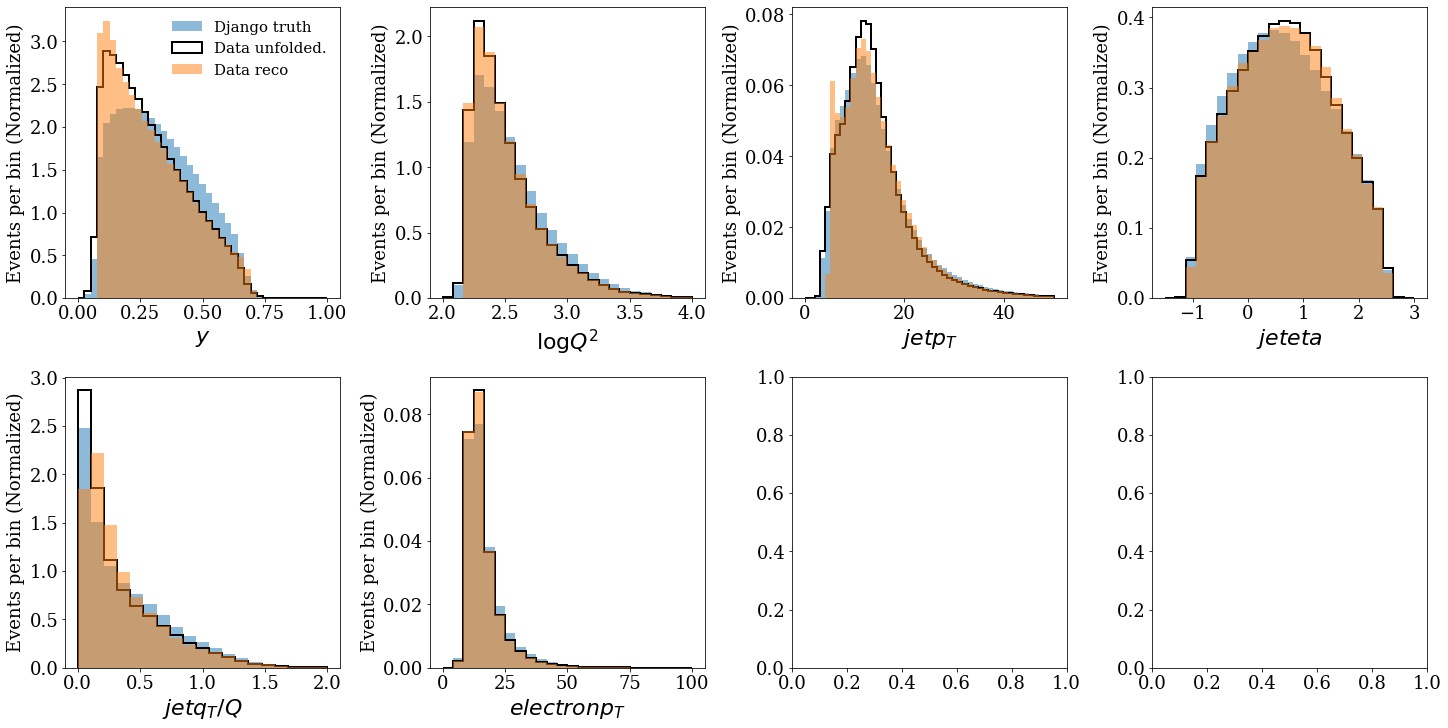

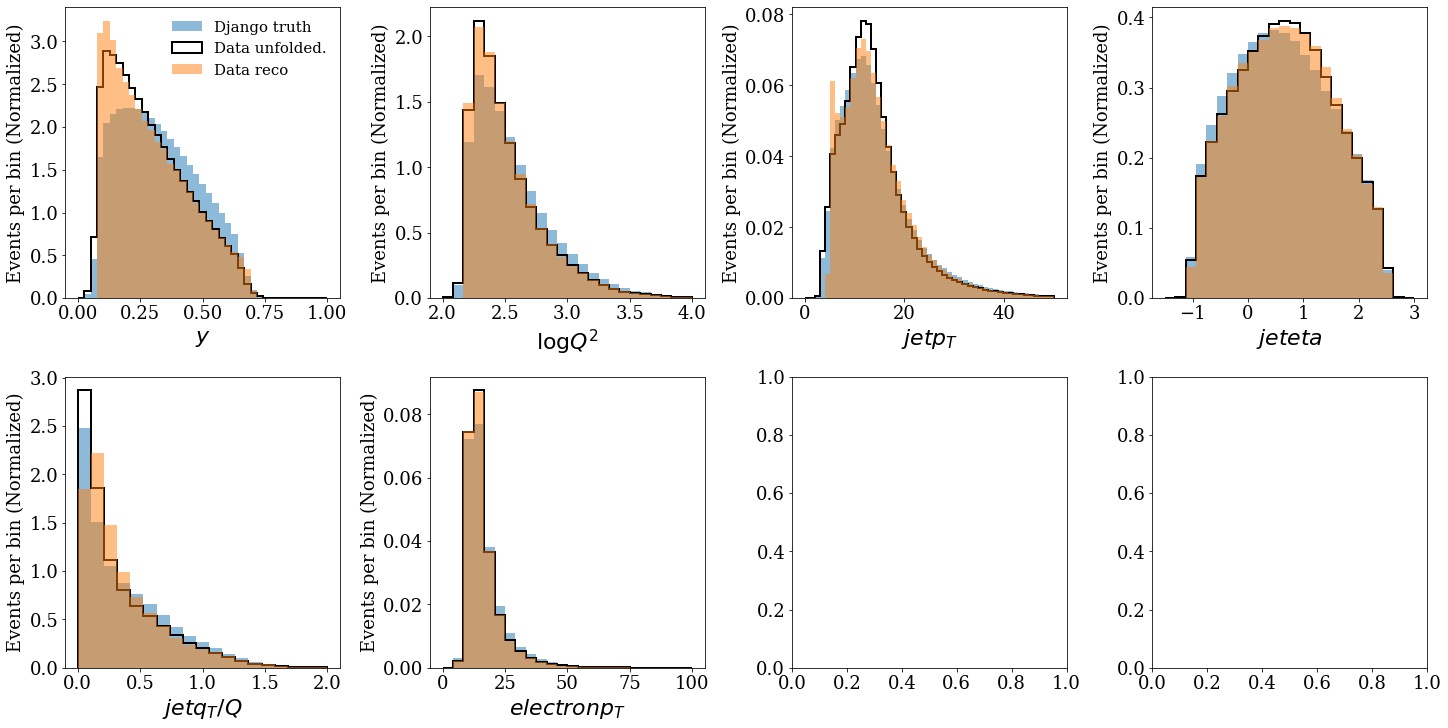

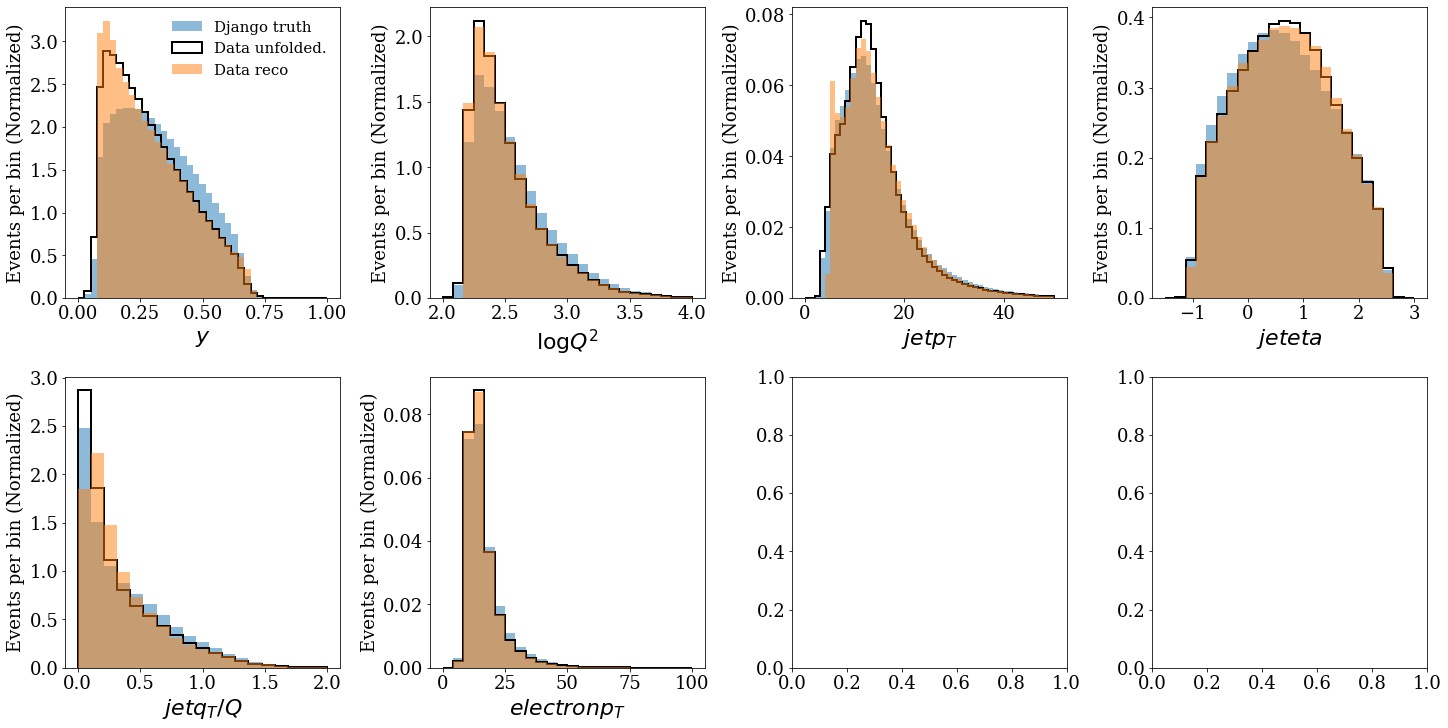

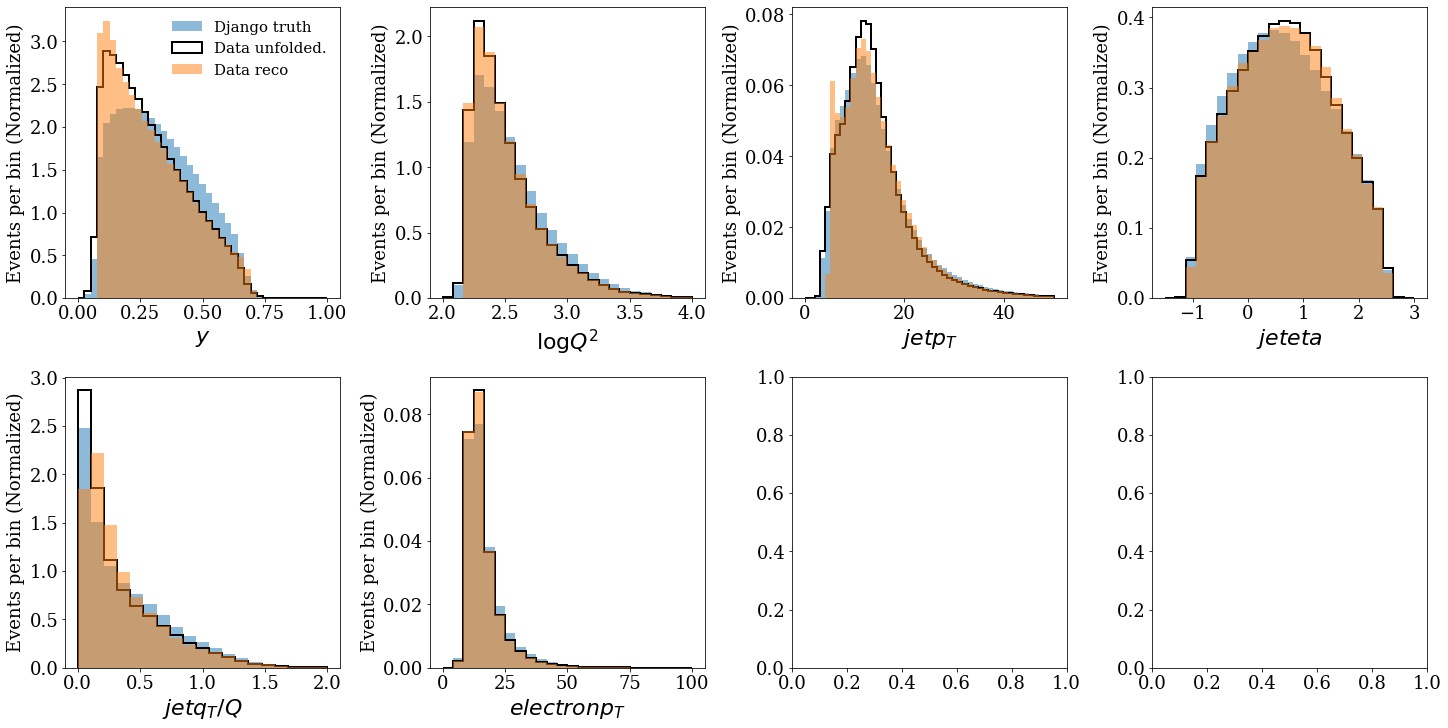

In [43]:
#event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
##track_selection = 'gen_track_pt>0.2'
#jet_selection    = 'gen_track_jetpt>15'
#query = 'pass_reco==1 and ' + event_selection + ' and ' + track_selection + ' and ' + jet_selection

query = 'pass_reco==1'
print('The query is:' , query)

label1 = r'Django truth'
label2 = r'Data unfolded.'
label3 = r'Data reco'

for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0,0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,0].legend(frameon=False)

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    

    
    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'], bins=bins, label=label1, **plot_style_2)
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    bins = np.linspace(0,2,20 )

    
    ax[1,0].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['genjet_qtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[1,0].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    
    #ax[1,1].set_yscale('log')

    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'], bins=bins, label=label1, **plot_style_2)
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    bins = np.linspace(0,100,25)

    ax[1,1].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[1,1].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    

## Jet pT spectrum data reco vs MC reco

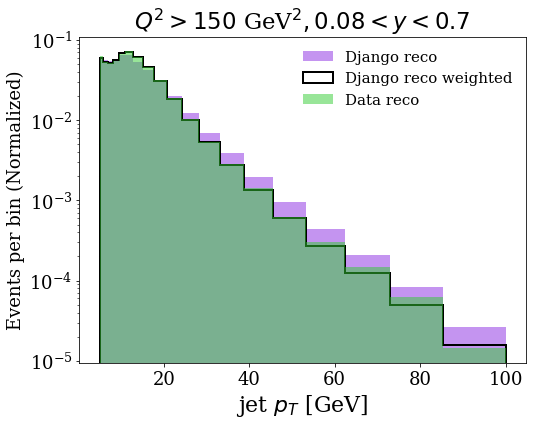

In [44]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(5),np.log10(100),20)
#bins = np.array([5,10,14,21,29,47,71,127])

#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_pt'], bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'jet $p_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/RealDataMC_jetpt_%s.png'%(mc_name)) 


In [ ]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.linspace(0,1,40)

plt.hist(mc_cut.query(query)['y'], bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=mc_name +' reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['y'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
#plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'y ',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  


fig.savefig('figures/DataMC_y_%s.png'%(mc_name)) 


## Data/MC agreement with differential 

Q>12.00 and Q<20.00 and pass_reco==1 and jet_pt>10
###########
Q>20.00 and Q<30.00 and pass_reco==1 and jet_pt>10
###########
Q>30.00 and Q<100.00 and pass_reco==1 and jet_pt>10
###########


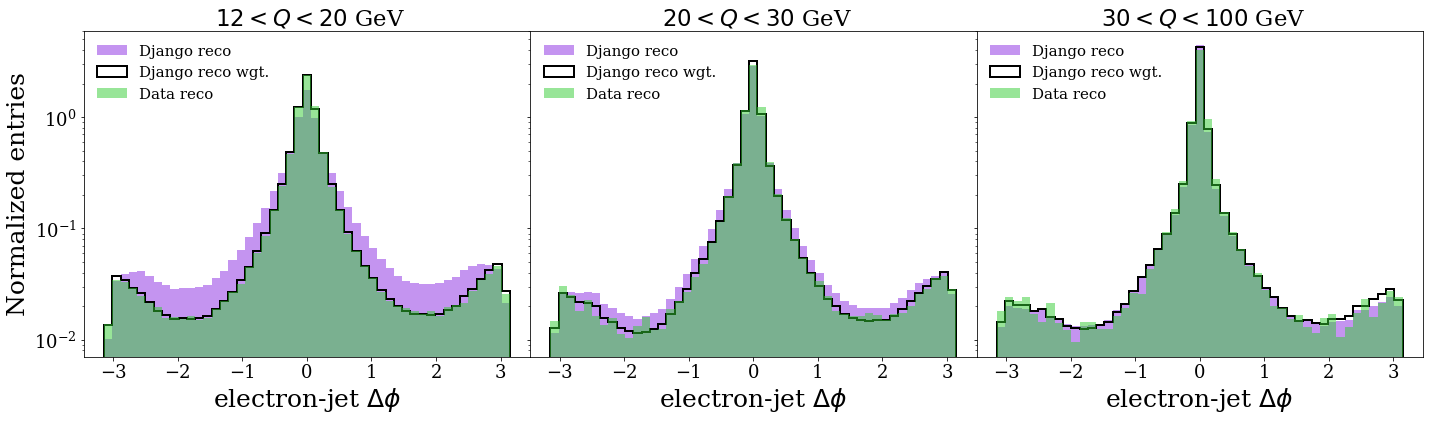

In [45]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.linspace(-np.pi,np.pi,50)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(24,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(12,20), (20,30),(30,100)]):
    #cut = ' Q2 > %2.2f and Q2 <%2.2f and pass_reco==1'%(edges[0],edges[1])
    cut = 'Q>%2.2f and Q<%2.2f and pass_reco==1 and jet_pt>10'%(edges[0],edges[1])
    print (cut)
    print ('###########')

    axs[counter].xaxis.set_label_text(r'electron-jet $\Delta\phi$', fontsize=25)


    
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'], bins=bins, label=mc_name+' reco', **plot_style_2,color=color1)
    axs[counter].hist(mc_cut.query(cut)['jet_dphi'],
               bins=bins,
               weights=mc_cut.query(cut)['weight_reco'],
               label=mc_name +' reco wgt.',
               **plot_style_1)
    axs[counter].hist(data_cut.query(cut)['jet_dphi'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)    
    
    
    axs[counter].legend(prop={'size': 15}, frameon=False, loc='upper left')
    axs[counter].set_title(' $ %2.0f < Q < %2.0f$ GeV'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    axs[counter].set_yscale('log')
    #axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)

fig.savefig('figures/RealDataMCcomparison_dphi_diff_%s.png'%(mc_name)) 


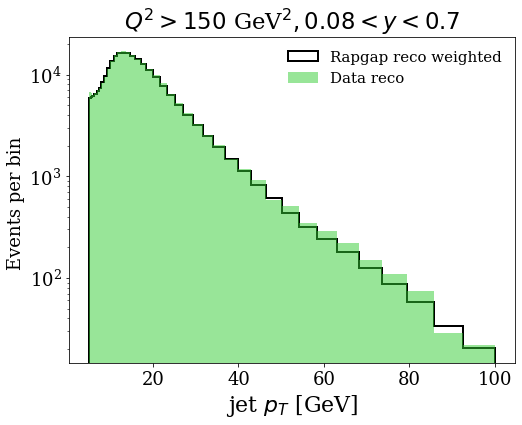

In [46]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.logspace(np.log10(5),np.log10(100),40)

plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label='Rapgap reco weighted', color='black', histtype='step', lw=2
               )

plt.hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label='Data reco',
               color=color2, alpha=0.5)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.08<y<0.7$')

plt.xlabel(r'jet $p_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin ')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
#fig.savefig('figures/jetpt_reco.png'%i)  



## Plot data, and unfolded results and MC truth

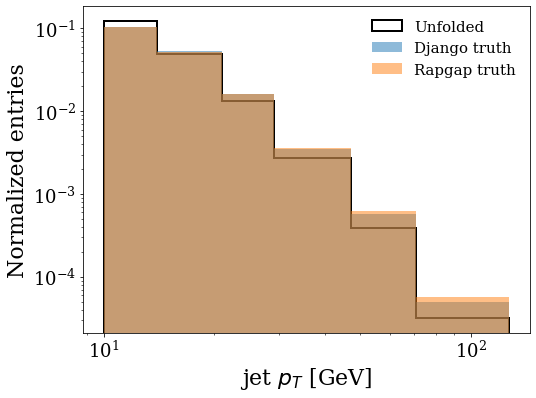

In [49]:
fig = plt.figure(figsize=(8,6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>5'
#bins = np.logspace(np.log10(15),np.log10(100),8)
bins = np.array([10,14,21,29,47,71,127])

#plt.hist(data['jet_pt'],bins=bins,label='Data (reco)',**plot_style_2)
#num,x,_ = plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label='Rapgap Truth',**plot_style_2)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label = 'Django truth',**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label = 'Rapgap truth',**plot_style_2)


plt.legend()
plt.ylabel('Normalized entries', fontsize=22)
plt.xlabel('jet $p_{T}$ [GeV]',fontsize=22)

plt.yscale('log')
plt.xscale('log')
fig.savefig('figures/Unfolded_jetpt_%s.png'%(mc_name)) 

plt.show()

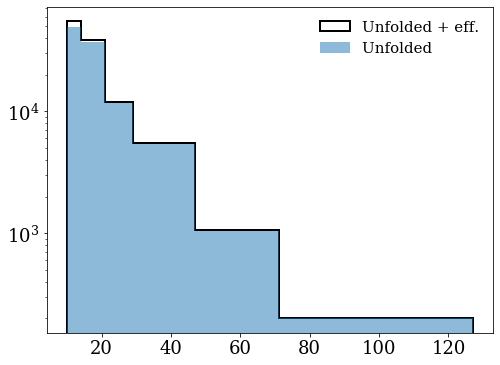

In [50]:
fig = plt.figure(figsize=(8,6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
bins = np.array([10,14,21,29,47,71,127])
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded + eff.',**plot_style_1A)

cut = cut+ ' and pass_reco==1'
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded ',**plot_style_2A)




plt.legend()
plt.yscale('log')
#plt.xscale('log')

plt.show()

In [ ]:
## Compare with HERA-ZEUS measurement

6
6
[1.36843433e+04 5.51578261e+03 1.49553534e+03 3.04531359e+02
 4.39871636e+01 3.59813192e+00]
[2.3996e+04 6.6220e+03 1.6236e+03 3.1600e+02 3.4920e+01 1.7320e+00]
[1.75353684 1.20055493 1.08563132 1.03765997 0.79386796 0.48136089]


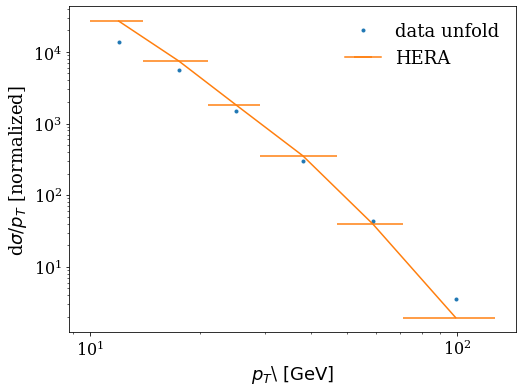

In [51]:

fig = plt.figure(figsize=(8,6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
bins = np.array([10,14,21,29,47,71,127])
y,x = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/(xerr*2.0)


plt.errorbar(x,y, fmt='.',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'$p_{T}$\ $[\mathrm{GeV}]$',fontsize=18)
plt.ylabel(r'd$\sigma$/$p_{T}$ [normalized]',fontsize=18)



#heray = np.array([2685, 1408,599.9,165.55,40.59,7.90, 0.873, 0.0433])
#heraxdo = np.array([6,8,10,14,21,29,47,71])
#heraxup = np.array([8,10,14,21,29,47,71,127])


heray = np.array([599.9,165.55,40.59,7.90, 0.873, 0.0433])
heraxdo = np.array([10,14,21,29,47,71])
heraxup = np.array([14,21,29,47,71,127])
heraerrx = (heraxup-heraxdo)/2.0
herax = (heraxup+heraxdo)/2.0

ratio = np.true_divide(40*heray,y)


print(len(herax))
print(len(heray))
plt.errorbar(herax, 45*heray,xerr=heraerrx,label='HERA')
plt.legend(loc='best',frameon=False,fontsize=18)

print(y)
print(40*heray)
plt.yscale('log')
plt.xscale('log')

print(ratio)

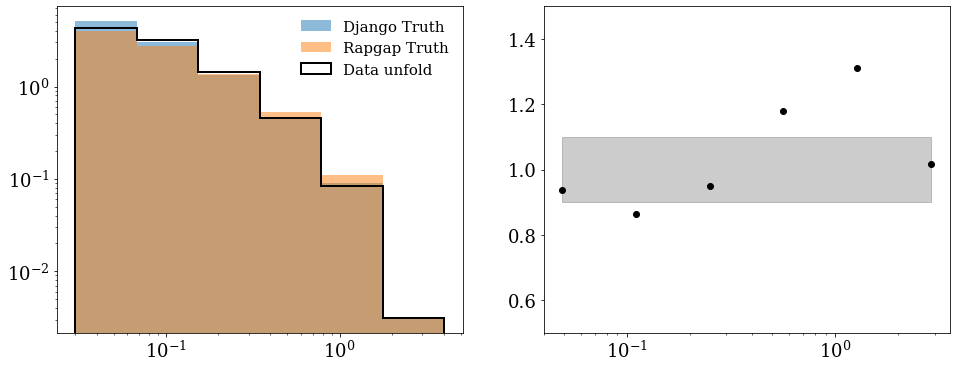

In [52]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
#bins = np.linspace(0,3,6)
bins = np.logspace(np.log10(0.03),np.log10(4),7)

ax[0].hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Django Truth',**plot_style_2)

num,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Rapgap Truth',**plot_style_2)

den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Data unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_yscale('log')

ax[0].set_xscale('log')
ax[1].set_xscale('log')


ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.9,1.1,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

plt.show()

In [53]:
#y, x  = np.histogram(df_jet['jet_pt'],bins=np.linspace(6,100,21))
cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
bins = np.array([10,14,21,29,47,71,127])
y, x  = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/(xerr*2.0)
integral = np.sum(y)

6
6


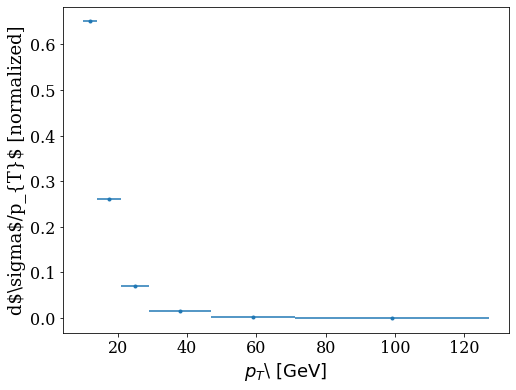

In [54]:
fig = plt.figure(figsize=(8,6))


plt.errorbar(x,y=y/integral,  xerr = xerr, fmt='.',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'$p_{T}$\ $[\mathrm{GeV}]$',fontsize=18)
plt.ylabel(r'd$\sigma$/p_{T}$ [normalized]',fontsize=18)



#heray = np.array([2685, 1408,599.9,165.55,40.59,7.90, 0.873, 0.0433])
#heraxdo = np.array([6,8,10,14,21,29,47,71])
#heraxup = np.array([8,10,14,21,29,47,71,127])


heray = np.array([599.9,165.55,40.59,7.90, 0.873, 0.0433])
heraxdo = np.array([10,14,21,29,47,71])
heraxup = np.array([14,21,29,47,71,127])
heraerrx = (heraxup-heraxdo)/2.0
herax = (heraxup+heraxdo)/2.0

ratio = np.true_divide(0.002*heray,y/integral)


print(len(herax))
print(len(heray))


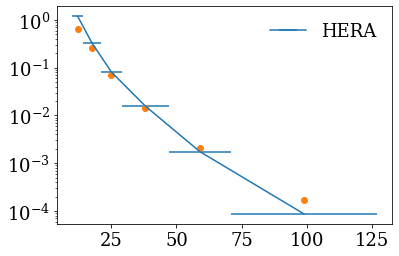

In [55]:
plt.errorbar(herax, 0.002*heray,xerr=heraerrx,label='HERA')
plt.plot(x,y/integral,'o')
plt.legend(loc='best',frameon=False,fontsize=18)
plt.yscale('log')

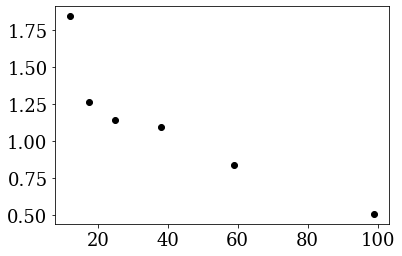

In [56]:
plt.plot(x,ratio,'o',color='black')

## Bootstrapping

In [ ]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


In [ ]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']

jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']


jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']


Q_0_G           = mc_cut['gen_Q']
Q_0_S           = mc_cut['Q']


In [ ]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G, Q_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S,Q_0_S)]
 

In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

In [ ]:
data_cut.head()

In [ ]:
K.clear_session()

In [ ]:
bootstraps = 50
iterations =  4
nvariables = 8
weights = [] 

import timeit


for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    K.clear_session()
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    epx_unknown_S       = bootstrap_data['e_px']
    epy_unknown_S       = bootstrap_data['e_py']
    epz_unknown_S       = bootstrap_data['e_pz'] 
    jetpt_unknown_S     = bootstrap_data['jet_pt']
    jeteta_unknown_S    = bootstrap_data['jet_eta']
    jetphi_unknown_S    = bootstrap_data['jet_phi']
    jetdphi_unknown_S   = bootstrap_data['jet_dphi']
    jetqt_unknown_S     = bootstrap_data['jet_qt']
    Q_unknown_S         = bootstrap_data['Q']
    theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, 
                            jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S, Q_unknown_S)]

    
    
    num_observables = 9
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S,
                       verbose =0
                      )
    
    
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)


In [ ]:
print(len(weights))

## for k in range(bootstraps):
    for i in range(len(weights[k])):
        print (weights[k].shape)
        print((weights[k][i, 1, :]).shape)
        print((weights[k][i, 1, :]).shape)
        print((weights[k][i, 1:2, :][0]).shape)


In [ ]:
covariance_matrices = []
for it in range(3):
    myns = []
    #bins = np.logspace(np.log10(0.01),np.log10(80),6)
    #bins = np.logspace(np.log10(0.1),np.log10(np.pi),20)
    #bins = np.array([0.0, 2.05491515, 2.45354097, 2.63853135,
    #                 2.8145858,  2.98213597, 3.14159265])

    bins = np.logspace(np.log10(0.03),np.log10(3),5)
    #bins = np.logspace(np.log10(10),np.log10(100),5)
    cut = 'gen_Q2>150 and gen_y>0.2 and gen_y<0.7 and pass_reco==1 and genjet_pt>10.0'
    for k in range(len(weights)):
        mc_cut['weight_temp'] =weights[k][it, 1, :]

        n,b,_ = plt.hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_temp'],alpha=0.3)
        myns+=[n]
        pass
    myns = np.array(myns)
    #print(myns)
    #plt.xlabel('tau1b')

    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

    covariance_matrices.append(corr)
    #fig, ax = plt.subplots() 
    #im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
    #                         interpolation='none')
    #fig.colorbar(im,ax=ax)

print(covariance_matrices[0])
plt.show()

#print (len(myns))
#print (len(myns[0]))

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(12,12)) 
minimo =-.40
maximo = 1.0

ax = ax.flatten()

im = ax[0].imshow(covariance_matrices[0],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[1].imshow(covariance_matrices[1],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[2].imshow(covariance_matrices[2],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
#im = ax[3].imshow(covariance_matrices[3],cmap='RdBu', vmin=minimo, vmax=1.0,
#                  interpolation='none')
#im = ax[4].imshow(covariance_matrices[4],cmap='RdBu', vmin=minimo, vmax =1.0,
#                  interpolation='none')
#im = ax[6].imshow(covariance_matrices[5],cmap='RdBu', vmin=minimo, vmax=1.0,
#                  interpolation='none')


ax[0].set_title('iteration #0')
ax[1].set_title('iteration #1')
ax[2].set_title('iteration #2')
ax[3].set_title('iteration #3')
ax[4].set_title('iteration #4')
ax[5].set_title('iteration #5')


plt.colorbar(im,ax=ax)
plt.show()

In [ ]:
from numpy.linalg import inv
x = [] 
rhos= []
for it in range(4): #iterations
    temp = []
    cov = np.matrix(covariance_matrices[it])
    inversecov = inv(cov)
    for i in range(cov.shape[0]):
         if(cov[i,i]*inversecov[i,i]!=0):
            temp.append( np.sqrt(1- 1.0/(cov[i,i]*inversecov[i,i])))
    rho_it = np.average(temp)
    rhos.append(rho_it)
    x.append(it+1)
    print (rho_it)
print (x)
print (rhos)

In [ ]:
np.logspace(np.log10(0.01),np.log10(3),6)

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,rhos,'-o')
plt.xlabel('Number of Multifold iterations',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [ ]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
fig, ax = plt.subplots() 
im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.show()